In [17]:
import pandas as pd
import seaborn as sb
import pylab as py
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium import plugins
from geopy.geocoders import Nominatim
import datetime
import statsmodels.api as sm
import statsmodels.stats as st
import scipy.stats as sp
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.diagnostic import het_goldfeldquandt

In [46]:
df = pd.read_csv('combined.csv')
df.head()

,Yearly Microplastics Emission,Mean BMI (female),AlcAmt,Cig/Adult,MedianAge,FirstChildAge,Reproductive Life Span
0,1400,23.267170,747.230,2408.999965,23.724996,24.740000,35.785938
1,1500,23.372925,784.310,2609.750035,23.907336,25.000000,35.823044
2,1800,23.451368,787.020,2701.000035,24.089675,25.133333,35.860151
3,2000,23.547950,796.570,2536.750017,24.272015,25.366667,35.897257
4,2200,23.648248,796.565,2682.749965,24.454354,25.250000,35.934363


In [47]:
df_female = pd.read_csv("female-pop.csv")
df_female = df_female.groupby("Year").sum()
df_female = df_female.reset_index()
df_female = df_female.loc[(df_female['Year'] >= 1980) & (df_female['Year'] <= 2010)]
df_female = df_female.reset_index()
df_female = df_female.drop(columns = ["index"])
df_female.head()

df_cancer = pd.read_csv('cancer.csv')
df_cancer = df_cancer.loc[(df_cancer['Year'] >= 1980) & (df_cancer['Year'] <= 2010)]
df_cancer['Cancer Rate'] = df_cancer.sum(axis=1) - df_cancer["Year"]
df_cancer = df_cancer.reset_index()
df_cancer = df_cancer.drop(columns = ["index"])
df_cancer = pd.concat([df_cancer['Year'], df_cancer['Cancer Rate']], axis = 1)
df_cancer["Cancer Rate"] = df_cancer["Cancer Rate"]/ df_female["PopFemale"] *100
# df_cancer["Cancer Rate"] = df_cancer["Cancer Rate"] * 0.3
df_cancer.head()

,Year,Cancer Rate
0,1980,0.069059
1,1981,0.069346
2,1982,0.075905
3,1983,0.090922
4,1984,0.092270


In [170]:
X.head()

,const,Yearly Microplastics Emission,Mean BMI (female),AlcAmt,Cig/Adult,FirstChildAge,Reproductive Life Span
0,1.0,1400,4.649815e+13,747.230,2408.999965,24.740000,35.785938
1,1.0,1500,4.865535e+13,784.310,2609.750035,25.000000,35.823044
2,1.0,1800,5.031319e+13,787.020,2701.000035,25.133333,35.860151
3,1.0,2000,5.242412e+13,796.570,2536.750017,25.366667,35.897257
4,1.0,2200,5.470030e+13,796.565,2682.749965,25.250000,35.934363


In [167]:
# X['Mean BMI (female)'] = np.log10(X['Mean BMI (female)'])
X['Mean BMI (female)'] = np.power(X['Mean BMI (female)'],10)

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
{X.columns[i]: variance_inflation_factor(X.values, i)                                                                                                                                   for i in range(1, X.shape[1])}

{'Yearly Microplastics Emission': 109.65591635022008,
 'Mean BMI (female)': 1934.5705518548614,
 'AlcAmt': 2.8498739675228606,
 'Cig/Adult': 8.098599500542585,
 'FirstChildAge': 29.45483392288755,
 'Reproductive Life Span': 1.9232888201927858}

In [166]:
X = df.drop(columns = ["MedianAge"])
X = sm.add_constant(X)

In [169]:
y = df_cancer['Cancer Rate']
y = y.reset_index().drop(columns = "index")
y = y.astype(float)

# Define the modell
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Fit the model
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            Cancer Rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     472.6
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           7.29e-24
Time:                        14:22:13   Log-Likelihood:                 129.24
No. Observations:                  31   AIC:                            -248.5
Df Residuals:                      26   BIC:                            -241.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

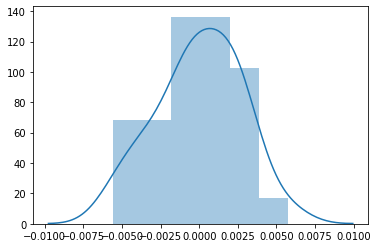

In [100]:
sb.distplot(model_fit.resid)

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  4.,  7., 16.]),
 array([-0.12131768, -0.09525257, -0.06918747, -0.04312237, -0.01705726,
         0.00900784,  0.03507295,  0.06113805,  0.08720315,  0.11326826,
         0.13933336]),
 <a list of 10 Patch objects>)

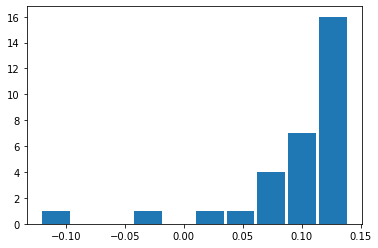

In [93]:
plt.hist(model_fit.resid, rwidth= 0.9)

In [94]:
print('ks test 1: ' + str(st.diagnostic.kstest_normal(model_fit.resid)[1]))
print('ks test 2: ' + str(sp.kstest(model_fit.resid,'norm')))
print('shapiro test: ' + str(sp.shapiro(model_fit.resid)))

ks test 1: 0.0005686819988937954
ks test 2: KstestResult(statistic=0.4517197094784895, pvalue=2.7015015229292503e-06)
shapiro test: (0.7077444791793823, 1.5150430954236072e-06)


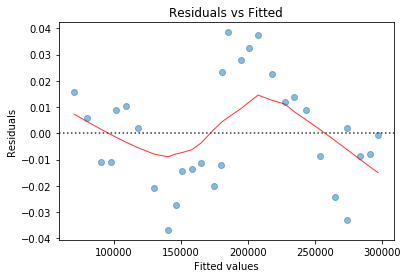

In [8]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sb.residplot(model_fitted_y, df.columns[-1], data=df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

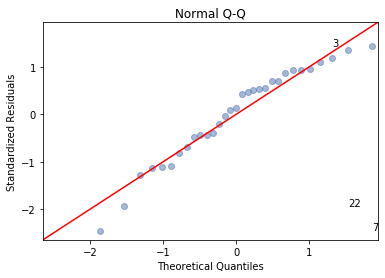

In [11]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

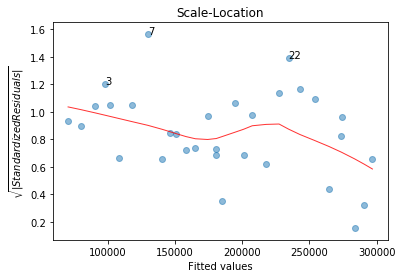

In [12]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sb.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));

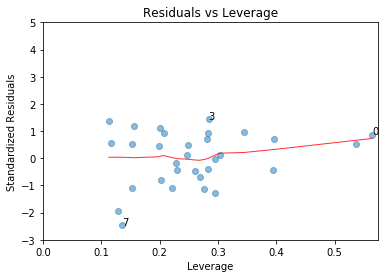

In [13]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sb.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));